# Imports

In [1]:
import glob
import os
import random
from typing import Callable, List, Union, Tuple

import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import softmax
from Bio.PDB.Polypeptide import index_to_one, one_to_index

from cavity_model import (
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
    ToTensor,
    CavityModel,
)
from visualization import scatter_pred_vs_true


%load_ext nb_black

<IPython.core.display.Javascript object>

# Cavity Model

Download and process Cavity Model data

In [2]:
# # Run shell script that takes a .txt file with PDBIDs as input.
# !./get_parse_pdbs_cavity_model.sh data/pdbids_010.txt

<IPython.core.display.Javascript object>

Global variables for Cavity Model Training

In [3]:
DEVICE = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT = 0.8
BATCH_SIZE = 100
LEARNING_RATE = 3e-4
EPOCHS = 10
PATIENCE_CUTOFF = 1

<IPython.core.display.Javascript object>

Load Parsed PDBs and perform train/val split

In [4]:
parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
random.shuffle(parsed_pdb_filenames)

n_train_pdbs = int(len(parsed_pdb_filenames) * TRAIN_VAL_SPLIT)
filenames_train = parsed_pdb_filenames[:n_train_pdbs]
filenames_val = parsed_pdb_filenames[n_train_pdbs:]

to_tensor_transformer = ToTensor(DEVICE)

dataset_train = ResidueEnvironmentsDataset(
    filenames_train, transformer=to_tensor_transformer
)
dataset_val = ResidueEnvironmentsDataset(
    filenames_val, transformer=to_tensor_transformer
)

dataloader_train = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=to_tensor_transformer.collate_cat,
    drop_last=True,
)
dataloader_val = DataLoader(
    dataset_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=to_tensor_transformer.collate_cat,
    drop_last=True,
)

print(
    f"Training data set includes {len(filenames_train)} pdbs with "
    f"{len(dataset_train)} environments."
)
print(
    f"Validation data set includes {len(filenames_val)} pdbs with "
    f"{len(dataset_val)} environments."
)

Training data set includes 8 pdbs with 4114 environments.
Validation data set includes 2 pdbs with 1144 environments.


<IPython.core.display.Javascript object>

Training helper functions

In [5]:
def _train_step(
    cavity_model_net: CavityModel,
    optimizer: torch.optim.Adam,
    loss_function: torch.nn.CrossEntropyLoss,
) -> (torch.Tensor, float):
    """
    Helper function to take a training step
    """
    cavity_model_net.train()
    optimizer.zero_grad()
    batch_y_pred = cavity_model_net(batch_x)
    loss_batch = loss_function(batch_y_pred, torch.argmax(batch_y, dim=-1))
    loss_batch.backward()
    optimizer.step()
    return (batch_y_pred, loss_batch.detach().cpu().item())


def _eval_loop(
    cavity_model_net: CavityModel,
    data_loader_val,
    loss_function: torch.nn.CrossEntropyLoss,
) -> (float, float):
    """
    Helper function to perform an eval loop
    """
    # Eval loop. Due to memory, we don't pass the whole eval set to the model
    labels_true_val = []
    labels_pred_val = []
    loss_batch_list_val = []
    for batch_x_val, batch_y_val in dataloader_val:
        cavity_model_net.eval()
        batch_y_pred_val = cavity_model_net(batch_x_val)

        loss_batch_val = loss_function(
            batch_y_pred_val, torch.argmax(batch_y_val, dim=-1)
        )
        loss_batch_list_val.append(loss_batch_val.detach().cpu().item())

        labels_true_val.append(torch.argmax(batch_y_val, dim=-1).detach().cpu().numpy())
        labels_pred_val.append(
            torch.argmax(batch_y_pred_val, dim=-1).detach().cpu().numpy()
        )
    acc_val = np.mean(
        (np.reshape(labels_true_val, -1) == np.reshape(labels_pred_val, -1))
    )
    loss_val = np.mean(loss_batch_list_val)
    return acc_val, loss_val

<IPython.core.display.Javascript object>

Train the cavity model

In [6]:
# Define model
cavity_model_net = CavityModel(DEVICE).to(DEVICE)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

# Create directory for model files
models_dirpath = "cavity_models/"
if not os.path.exists(models_dirpath):
    os.mkdir(models_dirpath)

# Train loop
current_best_epoch_idx = -1
current_best_loss_val = 1e4
patience = 0
epoch_idx_to_model_path = {}
for epoch in range(EPOCHS):
    labels_true = []
    labels_pred = []
    loss_batch_list = []
    for batch_x, batch_y in dataloader_train:
        # Take train step
        batch_y_pred, loss_batch = _train_step(
            cavity_model_net, optimizer, loss_function
        )
        loss_batch_list.append(loss_batch)

        labels_true.append(torch.argmax(batch_y, dim=-1).detach().cpu().numpy())
        labels_pred.append(torch.argmax(batch_y_pred, dim=-1).detach().cpu().numpy())

    # Train epoch metrics
    acc_train = np.mean((np.reshape(labels_true, -1) == np.reshape(labels_pred, -1)))
    loss_train = np.mean(loss_batch_list)

    # Validation epoch metrics
    acc_val, loss_val = _eval_loop(cavity_model_net, dataloader_val, loss_function)

    print(
        f"Epoch {epoch:2d}. Train loss: {loss_train:5.3f}. "
        f"Train Acc: {acc_train:4.2f}. Val loss: {loss_val:5.3f}. "
        f"Val Acc {acc_val:4.2f}"
    )

    # Save model
    model_path = f"cavity_models/model_epoch_{epoch:02d}.pt"
    epoch_idx_to_model_path[epoch] = model_path
    torch.save(cavity_model_net.state_dict(), model_path)

    # Early stopping
    if loss_val < current_best_loss_val:
        current_best_loss_val = loss_val
        current_best_epoch_idx = epoch
        patience = 0
    else:
        patience += 1
    if patience > PATIENCE_CUTOFF:
        print(f"Early stopping activated.")
        break

print(
    f"Best epoch idx: {current_best_epoch_idx} with validation loss: "
    f"{current_best_loss_val:5.3f} and model_path: "
    f"{epoch_idx_to_model_path[current_best_epoch_idx]}"
)

Epoch  0. Train loss: 2.455. Train Acc: 0.32. Val loss: 3.196. Val Acc 0.07
Epoch  1. Train loss: 1.233. Train Acc: 0.79. Val loss: 2.750. Val Acc 0.20
Epoch  2. Train loss: 0.688. Train Acc: 0.94. Val loss: 2.766. Val Acc 0.21
Epoch  3. Train loss: 0.354. Train Acc: 0.99. Val loss: 2.816. Val Acc 0.20
Early stopping activated.
Best epoch idx: 1 with validation loss: 2.750 and model_path: cavity_models/model_epoch_01.pt


<IPython.core.display.Javascript object>

# ddG Prediction

Global variables

In [7]:
EPS = 1e-9

<IPython.core.display.Javascript object>

Parse PDBs for DMS, Guerois and Protein G data sets

In [8]:
# # Parse PDBs for which we have ddG data
# !./get_parse_pdbs_dowstream_task.sh

<IPython.core.display.Javascript object>

Make dict for residue environments for easy look up

In [9]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

Load ddG data to dataframe

In [10]:
from collections import OrderedDict

ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric": pd.read_csv("data/data_symmetric/ddgs_parsed.csv"),
    #     "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    #     "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}

<IPython.core.display.Javascript object>

Populate dataframes with wt ResidueEnvironment objects and wt and mt restype indices

In [11]:
print(
    "Dropping data points where residue is not defined in structure "
    f"or due to missing parsed pdb file"
)
# Add wt residue environments to standard ddg data dataframes
for ddg_data_key in ["dms", "protein_g", "guerois"]:
    resenvs_ddg_data = []
    for idx, row in ddg_data_dict[ddg_data_key].iterrows():
        resenv_key = (
            f"{row['pdbid']}{row['chainid']}_"
            f"{row['variant'][1:-1]}{row['variant'][0]}"
        )
        try:
            resenv = resenv_datasets_look_up[ddg_data_key][resenv_key]
            resenvs_ddg_data.append(resenv)
        except KeyError:
            resenvs_ddg_data.append(np.nan)
    ddg_data_dict[ddg_data_key]["resenv"] = resenvs_ddg_data
    n_datapoints_before = ddg_data_dict[ddg_data_key].shape[0]
    ddg_data_dict[ddg_data_key].dropna(inplace=True)
    n_datapoints_after = ddg_data_dict[ddg_data_key].shape[0]
    print(
        f"dropped {n_datapoints_before - n_datapoints_after:4d} / "
        f"{n_datapoints_before:4d} data points from dataset {ddg_data_key}"
    )

    # Add wt and mt idxs to df
    ddg_data_dict[ddg_data_key]["wt_idx"] = ddg_data_dict[ddg_data_key].apply(
        lambda row: one_to_index(row["variant"][0]), axis=1
    )
    ddg_data_dict[ddg_data_key]["mt_idx"] = ddg_data_dict[ddg_data_key].apply(
        lambda row: one_to_index(row["variant"][-1]), axis=1
    )

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois


<IPython.core.display.Javascript object>

Populate dataframes with predicted NLLs and isolated WT and MT predicted NLLs as well as NLFs

In [12]:
# Load best performing cavity model from previos trainig
cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
cavity_model_infer_net.load_state_dict(
    torch.load(epoch_idx_to_model_path[current_best_epoch_idx])
)
cavity_model_infer_net.eval()

# Load PDB amino acid frequencies used to approximate unfolded states
pdb_nlfs = -np.log(np.load("data/pdb_frequencies.npz")["frequencies"])

# Add predicted to Nlls ddG dataframes
for ddg_data_key in ["dms", "protein_g", "guerois"]:
    df = ddg_data_dict[ddg_data_key]

    # Perform predictions on matched residue environments
    ddg_resenvs = list(df["resenv"].values)
    ddg_resenv_dataset = ResidueEnvironmentsDataset(
        ddg_resenvs, transformer=ToTensor(DEVICE)
    )

    # Define dataloader for resenvs matched to ddG data
    ddg_resenv_dataloader = DataLoader(
        ddg_resenv_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=to_tensor_transformer.collate_cat,
        drop_last=False,
    )

    # Infer NLLs
    pred_nlls = []
    for batch_x, _ in ddg_resenv_dataloader:
        batch_pred_nlls = (
            -torch.log(softmax(cavity_model_infer_net(batch_x), dim=-1) + EPS)
            .detach()
            .cpu()
            .numpy()
        )
        pred_nlls.append(batch_pred_nlls)
    pred_nlls_list = [row for row in np.vstack(pred_nlls)]

    # Add NLLs to dataframe
    df["nlls"] = pred_nlls_list

    # Isolate WT and MT NLLs and add to datafra
    df["wt_nll"] = df.apply(lambda row: row["nlls"][row["wt_idx"]], axis=1)
    df["mt_nll"] = df.apply(lambda row: row["nlls"][row["mt_idx"]], axis=1)

    # Add PDB database statistics negative log frequencies to df
    df["wt_nlf"] = df.apply(lambda row: pdb_nlfs[row["wt_idx"]], axis=1)
    df["mt_nlf"] = df.apply(lambda row: pdb_nlfs[row["mt_idx"]], axis=1)

    # Add ddG prediction (without downstream model)
    df["ddg_pred_no_ds"] = df.apply(
        lambda row: row["mt_nll"] - row["mt_nlf"] - row["wt_nll"] + row["wt_nlf"],
        axis=1,
    )

    display(ddg_data_dict[ddg_data_key])

,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
120,1D5R,A,R14A,-0.087552,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,0,"[3.8025663, 3.7633724, 1.5189456, 3.3070707, 4...",3.292686,3.802566,3.035567,2.483982,1.061464
121,1D5R,A,R14D,-0.142873,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,2,"[3.8025663, 3.7633724, 1.5189456, 3.3070707, 4...",3.292686,1.518946,3.035567,2.824680,-1.562854
122,1D5R,A,R14E,0.001090,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,3,"[3.8025663, 3.7633724, 1.5189456, 3.3070707, 4...",3.292686,3.307071,3.035567,2.712832,0.337119
123,1D5R,A,R14G,-0.046315,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,5,"[3.8025663, 3.7633724, 1.5189456, 3.3070707, 4...",3.292686,2.114091,3.035567,2.560213,-0.703242
124,1D5R,A,R14I,0.335560,<ResidueEnvironment with 141 atoms. pdb_id: 1D...,14,7,"[3.8025663, 3.7633724, 1.5189456, 3.3070707, 4...",3.292686,4.300806,3.035567,2.854018,1.189668
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8091,2H11,A,K245R,0.168083,<ResidueEnvironment with 114 atoms. pdb_id: 2H...,8,14,"[2.2288208, 4.069526, 2.2686608, 3.2985134, 4....",1.948184,3.242992,2.828313,3.035567,1.087555
8092,2H11,A,K245S,0.334371,<ResidueEnvironment with 114 atoms. pdb_id: 2H...,8,15,"[2.2288208, 4.069526, 2.2686608, 3.2985134, 4....",1.948184,2.022223,2.828313,2.844502,0.057851
8093,2H11,A,K245T,0.099750,<ResidueEnvironment with 114 atoms. pdb_id: 2H...,8,16,"[2.2288208, 4.069526, 2.2686608, 3.2985134, 4....",1.948184,4.045475,2.828313,2.896883,2.028722
8094,2H11,A,K245V,0.328221,<ResidueEnvironment with 114 atoms. pdb_id: 2H...,8,17,"[2.2288208, 4.069526, 2.2686608, 3.2985134, 4....",1.948184,3.800766,2.828313,2.623741,2.057154


,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
0,1PGA,A,M1A,-0.1407,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,0,"[3.5781014, 3.3262599, 2.7936864, 2.4017062, 2...",3.435004,3.578101,3.785957,2.483982,1.445071
1,1PGA,A,M1D,-0.3795,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,2,"[3.5781014, 3.3262599, 2.7936864, 2.4017062, 2...",3.435004,2.793686,3.785957,2.824680,0.319959
2,1PGA,A,M1E,-0.6414,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,3,"[3.5781014, 3.3262599, 2.7936864, 2.4017062, 2...",3.435004,2.401706,3.785957,2.712832,0.039826
3,1PGA,A,M1L,-0.4573,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,9,"[3.5781014, 3.3262599, 2.7936864, 2.4017062, 2...",3.435004,3.587862,3.785957,2.433114,1.505701
4,1PGA,A,T2E,-0.1299,<ResidueEnvironment with 157 atoms. pdb_id: 1P...,16,3,"[3.285576, 3.0978632, 2.0178604, 3.0171888, 4....",2.791233,3.017189,2.896883,2.712832,0.410006
...,...,...,...,...,...,...,...,...,...,...,...,...,...
902,1PGA,A,M1Q,-0.4025,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,13,"[3.6060934, 3.3772283, 2.7461443, 2.3837523, 2...",3.346203,2.726833,3.785957,3.338515,-0.171928
903,1PGA,A,M1R,-0.5102,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,14,"[3.6060934, 3.3772283, 2.7461443, 2.3837523, 2...",3.346203,3.465726,3.785957,3.035567,0.869912
904,1PGA,A,M1S,-0.6800,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,15,"[3.6060934, 3.3772283, 2.7461443, 2.3837523, 2...",3.346203,3.609352,3.785957,2.844502,1.204604
905,1PGA,A,M1T,-0.4983,<ResidueEnvironment with 130 atoms. pdb_id: 1P...,10,16,"[3.6060934, 3.3772283, 2.7461443, 2.3837523, 2...",3.346203,3.230519,3.785957,2.896883,0.773390


,pdbid,chainid,variant,ddg,resenv,wt_idx,mt_idx,nlls,wt_nll,mt_nll,wt_nlf,mt_nlf,ddg_pred_no_ds
0,171L,A,A45E,0.01,<ResidueEnvironment with 189 atoms. pdb_id: 17...,0,3,"[3.5631006, 2.1874328, 2.3202763, 2.80826, 3.5...",3.563101,2.808260,2.483982,2.712832,-0.983691
1,1A2P,A,Y103F,0.00,<ResidueEnvironment with 211 atoms. pdb_id: 1A...,19,4,"[3.477947, 2.8745575, 1.9781679, 4.224713, 3.2...",3.579012,3.243207,3.311580,3.207937,-0.232163
2,1A2P,A,T105V,2.24,<ResidueEnvironment with 157 atoms. pdb_id: 1A...,16,17,"[3.9143703, 3.2882202, 1.1717467, 2.6038277, 4...",2.301807,2.903762,2.896883,2.623741,0.875095
3,1A2P,A,I109A,2.07,<ResidueEnvironment with 182 atoms. pdb_id: 1A...,7,0,"[3.3919, 3.107206, 3.487698, 2.9330328, 3.3578...",3.133065,3.391900,2.854018,2.483982,0.628870
4,1A2P,A,I109V,0.76,<ResidueEnvironment with 182 atoms. pdb_id: 1A...,7,17,"[3.2360377, 3.167153, 3.4993625, 2.9301527, 3....",3.186593,2.542341,2.854018,2.623741,-0.413975
...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,4LYZ,A,D101N,-0.04,<ResidueEnvironment with 124 atoms. pdb_id: 4L...,2,11,"[4.3361855, 3.1996963, 1.9165608, 2.587359, 3....",1.916561,4.141316,2.824680,3.127102,1.922333
907,4LYZ,A,I55A,4.40,<ResidueEnvironment with 320 atoms. pdb_id: 4L...,7,0,"[2.7750816, 3.0358958, 2.8982973, 3.947209, 3....",3.513134,2.775082,2.854018,2.483982,-0.368017
908,4LYZ,A,I55T,4.96,<ResidueEnvironment with 320 atoms. pdb_id: 4L...,7,16,"[2.7750816, 3.0358958, 2.8982973, 3.947209, 3....",3.513134,2.802106,2.854018,2.896883,-0.753892
909,4LYZ,A,I55V,0.91,<ResidueEnvironment with 320 atoms. pdb_id: 4L...,7,17,"[2.7750816, 3.0358958, 2.8982973, 3.947209, 3....",3.513134,3.614568,2.854018,2.623741,0.331711


<IPython.core.display.Javascript object>

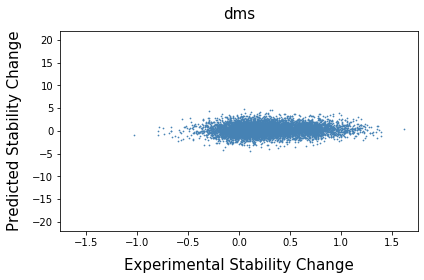

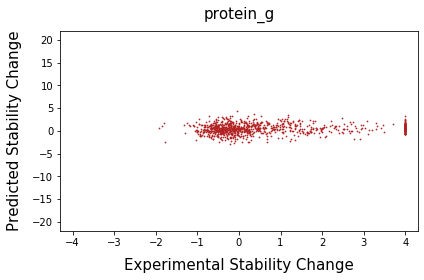

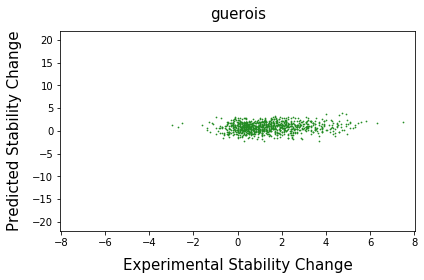

<IPython.core.display.Javascript object>

In [13]:
colors = ["steelblue", "firebrick", "forestgreen"]
for idx, data_key in enumerate(["dms", "protein_g", "guerois"]):
    fig, ax = scatter_pred_vs_true(
        ddg_data_dict[data_key]["ddg"],
        ddg_data_dict[data_key]["ddg_pred_no_ds"],
        color=colors[idx],
        title=data_key,
    )